# DREAM5 - SGBM benchmark (norm vs denorm)

* updated for Arboreto 0.1.4

In [1]:
import os
import sys
sys.path.append('../../')

from arboreto.core import *
from arboreto.utils import *

import matplotlib.pyplot as plt
import pandas as pd

## Data paths

In [2]:
wd = os.getcwd().split('arboreto')[0] + 'arboreto/resources/dream5/'

net1_ex_path = wd + 'net1/net1_expression_data.tsv'
net1_tf_path = wd + 'net1/net1_transcription_factors.tsv'

net3_ex_path = wd + 'net3/net3_expression_data.tsv'
net3_tf_path = wd + 'net3/net3_transcription_factors.tsv'

net4_ex_path = wd + 'net4/net4_expression_data.tsv'
net4_tf_path = wd + 'net4/net4_transcription_factors.tsv'

## Dask client

In [3]:
from dask.distributed import Client, LocalCluster

In [4]:
client = Client(LocalCluster())

In [5]:
client

Client Scheduler: tcp://127.0.0.1:46813 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 88 Cores: 88 Memory: 135.07 GB


Use port forwarding to view the dashboard `$ ssh -L 8000:localhost:8787 nostromo`

In [6]:
# client.shutdown()

## Infer networks (with meta)

In [7]:
def infer_network_and_meta(ex_path, tf_path, client):
    ex_matrix = pd.read_csv(ex_path, sep='\t')    
    gene_names = list(ex_matrix.columns)
    tf_names = load_tf_names(tf_path)
    
    network_graph, meta_graph = create_graph(ex_matrix.as_matrix(),
                                             gene_names,
                                             tf_names,
                                             "GBM",
                                             SGBM_KWARGS,
                                             client=client,
                                             target_genes='all',  
                                             early_stop_window_length=25,
                                             include_meta=True)

    a, b = client.persist([network_graph, meta_graph])

    return a.compute(sync=True), b.compute(sync=True)

In [8]:
%%time
net1, meta1 = infer_network_and_meta(net1_ex_path, net1_tf_path, client)

CPU times: user 36.8 s, sys: 9.59 s, total: 46.4 s
Wall time: 49.1 s


In [9]:
%%time
net3, meta3 = infer_network_and_meta(net3_ex_path, net3_tf_path, client)

CPU times: user 2min 12s, sys: 41 s, total: 2min 53s
Wall time: 3min 28s


In [10]:
%%time
net4, meta4 = infer_network_and_meta(net4_ex_path, net4_tf_path, client)

CPU times: user 2min 11s, sys: 36.4 s, total: 2min 47s
Wall time: 3min 25s


In [16]:
out_wd = 'dream5_norm_vs_denorm/'

net1.to_csv(out_wd + 'raw.net1.tsv', index=False, sep='\t')
meta1.to_csv(out_wd + 'raw.meta1.tsv', index=False, sep='\t')

net3.to_csv(out_wd + 'raw.net3.tsv', index=False, sep='\t')
meta3.to_csv(out_wd + 'raw.meta3.tsv', index=False, sep='\t')

net4.to_csv(out_wd + 'raw.net4.tsv', index=False, sep='\t')
meta4.to_csv(out_wd + 'raw.meta4.tsv', index=False, sep='\t')

In [17]:
from fixed_scoring import D5C4

In [56]:
def normalized(net, meta):
    merged_df = net.merge(meta)
    
    merged_df['importance'] = merged_df['importance'] / merged_df['n_estimators']
    
    return merged_df[['TF', 'target', 'importance']]

In [57]:
def write_top(df_links, out_path, n=100000):
    """
    Write the links to the specified output path.
    """
    df_links.nlargest(n, columns=['importance']).to_csv(out_path, index=False, header=False, sep='\t')

In [60]:
net1_norm_path = out_wd + 'net1.norm.tsv'
net3_norm_path = out_wd + 'net3.norm.tsv'
net4_norm_path = out_wd + 'net4.norm.tsv'

write_top(normalized(net1, meta1), net1_norm_path)
write_top(normalized(net3, meta1), net3_norm_path)
write_top(normalized(net4, meta1), net4_norm_path)

In [61]:
net1_path = out_wd + 'net1.tsv'
net3_path = out_wd + 'net3.tsv'
net4_path = out_wd + 'net4.tsv'

write_top(net1, net1_path)
write_top(net3, net3_path)
write_top(net4, net4_path)

In [62]:
s = D5C4()
norm_score = s.score([net1_norm_path, net3_norm_path, net4_norm_path])

Missing README.rst. Please add one in D5C4
The 3 files must be ordered as network 1, 3 and 4
Scanning gold standard
Scanning gold standard
Scanning gold standard
68.1768044266 32.0835980492 50.1302012379


In [63]:
denorm_score = s.score([net1_path, net3_path, net4_path])

The 3 files must be ordered as network 1, 3 and 4
Scanning gold standard
Scanning gold standard
Scanning gold standard
83.8002359129 44.2975651996 64.0489005563


In [67]:
norm_score.to_csv(out_wd + 'normalized_eval.txt', sep='\t')

In [68]:
denorm_score.to_csv(out_wd + 'denormalized_eval.txt', sep='\t')

## Plotting top importance by nr of boosting rounds

In [145]:
def scatter_top_importance_by_rounds(net, meta, n=1, hi=None, lo=None):
    df = meta.merge(net.groupby(['target'])['importance'].nlargest(n).reset_index(), 
                    how='inner', 
                    on=['target'])
    
    if hi:
        df = df[df['importance'] < hi]
        
    if lo:
        df = df[df['importance'] > lo]
        
    if len(df) == 0:
        raise Error('df has no entries')
            
    print(len(df))    
        
    df.plot.scatter(x='n_estimators', 
                    y='importance', 
                    figsize=(16, 9))
    plt.show()

In [118]:
def hexbin_top_importance_by_rounds(net, meta, n=1):
    meta.merge(net.groupby(['target'])['importance'].nlargest(n).reset_index(), 
               how='left', 
               on=['target']).plot.hexbin(x='n_estimators', 
                                          y='importance',   
                                          bins='log',
                                          cmap=plt.get_cmap("inferno"),
                                          figsize=(16, 9))
    plt.show()

In [17]:
net4.nlargest(100000, columns=['importance']).head()

,TF,target,importance
37,G38,G243,141.018922
140,G141,G2710,139.493231
241,G243,G38,123.243948
287,G288,G1082,116.486176
114,G115,G729,105.002217


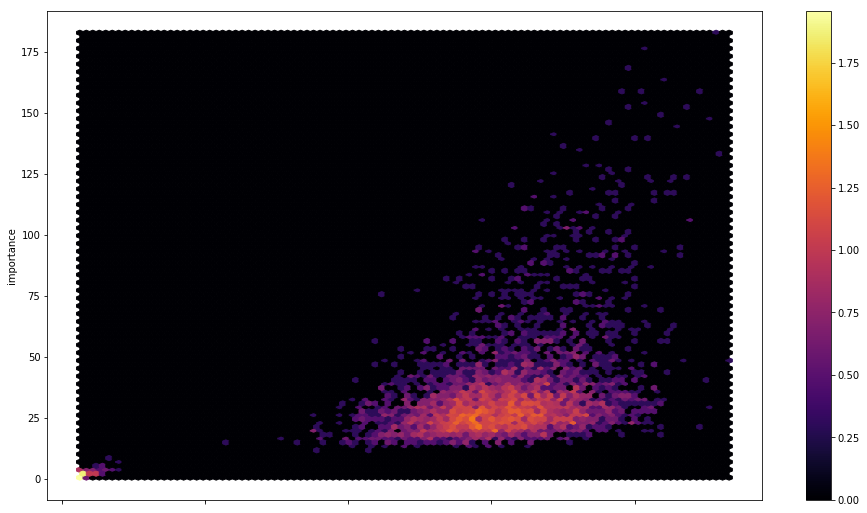

In [23]:
hexbin_top_importance_by_rounds(net3, meta3)

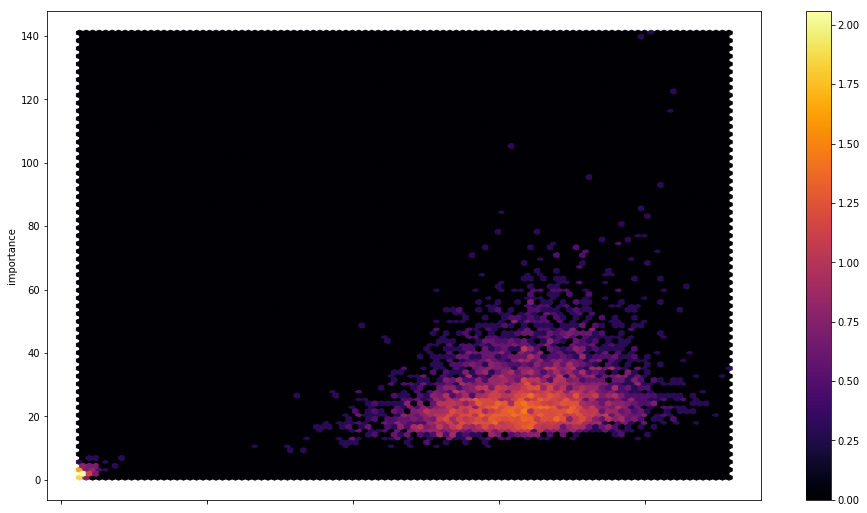

In [24]:
hexbin_top_importance_by_rounds(net4, meta4)

In [26]:
write_top(net1, 'net1.tsv')

In [28]:
write_top(net3, 'net3.tsv')

In [27]:
write_top(net4, 'net4.tsv')

## DREAM5 benchmark evaluation

In [12]:
eval_df = pd.read_csv('eval.sgbm.denorm.win.25.txt')

In [13]:
eval_df

,metric,GRNBoost,GENIE3
0,Overall Score,6.411590e+01,4.027898e+01
1,AUPR (pvalue),8.399037e+01,4.129532e+01
2,AUROC (pvalue),4.424144e+01,3.926265e+01
3,Net1 AUPR,3.558841e-01,2.909863e-01
4,Net3 AUPR,1.222214e-01,9.302545e-02
5,Net4 AUPR,2.299922e-02,2.065091e-02
6,Net1 AUROC,8.155145e-01,8.148355e-01
7,Net3 AUROC,6.335665e-01,6.170165e-01
8,Net4 AUROC,5.238476e-01,5.176411e-01
9,Net1 p-aupr,4.313612e-207,1.596591e-104


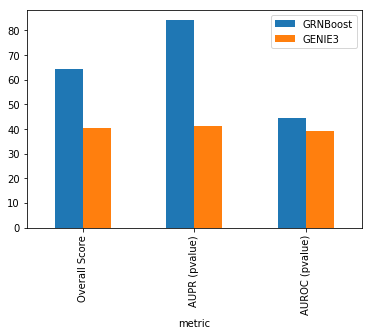

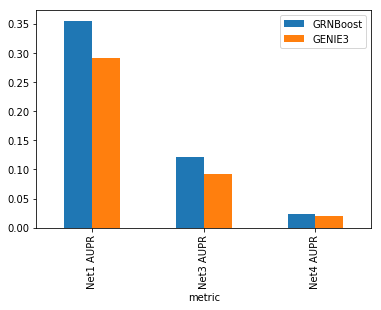

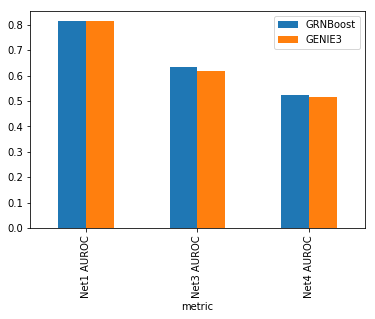

In [17]:
eval_df[:3].plot.bar(x='metric')
eval_df[3:6].plot.bar(x='metric')
eval_df[6:9].plot.bar(x='metric')
plt.show()

# Reading back in

In [71]:
data_wd = 'dream5_norm_vs_denorm/'

In [91]:
net1_norm   = pd.read_csv(data_wd + 'net1.norm.tsv', header=None, sep='\t', names=['TF', 'target', 'importance'])
net1_denorm = pd.read_csv(data_wd + 'net1.tsv', header=None, sep='\t', names=['TF', 'target', 'importance'])

net3_norm   = pd.read_csv(data_wd + 'net3.norm.tsv', header=None, sep='\t', names=['TF', 'target', 'importance'])
net3_denorm = pd.read_csv(data_wd + 'net3.tsv', header=None, sep='\t', names=['TF', 'target', 'importance'])

net4_norm   = pd.read_csv(data_wd + 'net4.norm.tsv', header=None, sep='\t', names=['TF', 'target', 'importance'])
net4_denorm = pd.read_csv(data_wd + 'net4.tsv', header=None, sep='\t', names=['TF', 'target', 'importance'])

In [94]:
net1_meta = pd.read_csv(data_wd + 'raw.meta1.tsv', sep='\t')
net3_meta = pd.read_csv(data_wd + 'raw.meta3.tsv', sep='\t')
net4_meta = pd.read_csv(data_wd + 'raw.meta4.tsv', sep='\t')

In [89]:
net1_norm.merge(net1_meta).head()

,TF,target,importance,n_estimators
0,G10,G1312,0.225515,511
1,G84,G1312,0.036993,511
2,G131,G1312,0.034928,511
3,G121,G1312,0.031437,511
4,G22,G1312,0.017701,511


In [110]:
N = 1

1643


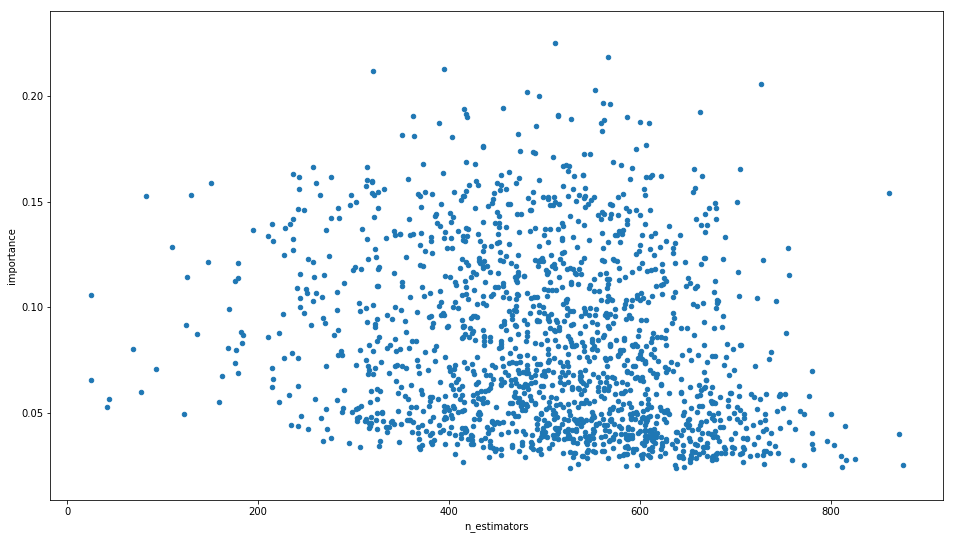

1642


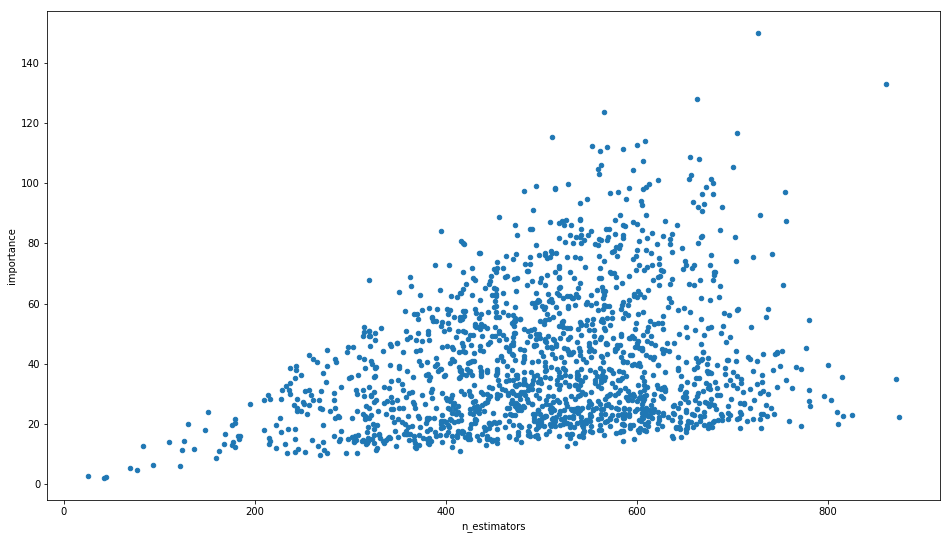

In [146]:
scatter_top_importance_by_rounds(net1_norm, net1_meta, n=N)
scatter_top_importance_by_rounds(net1_denorm, net1_meta, n=N)

In [147]:
net3_denorm.dtypes

TF             object
target         object
importance    float64
dtype: object

1572


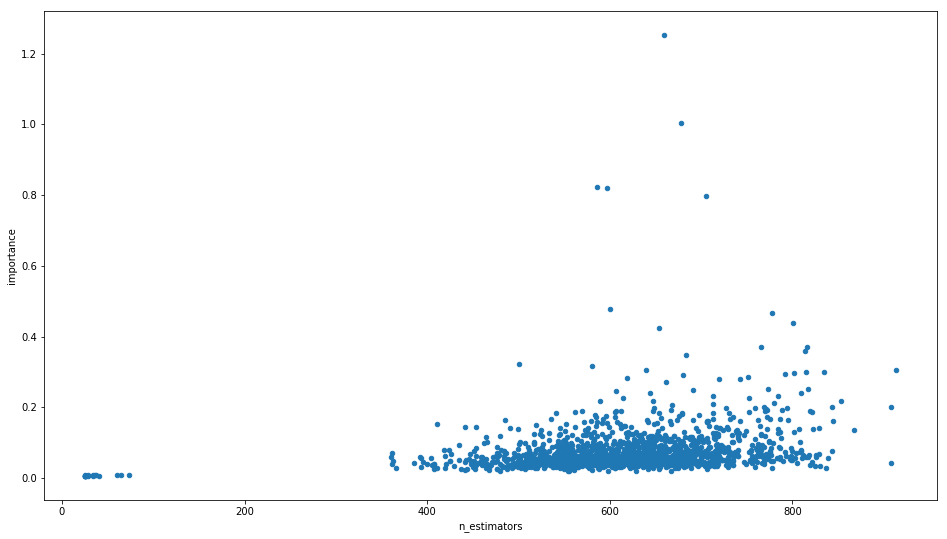

In [148]:
scatter_top_importance_by_rounds(net3_norm, net3_meta, n=N)

4300


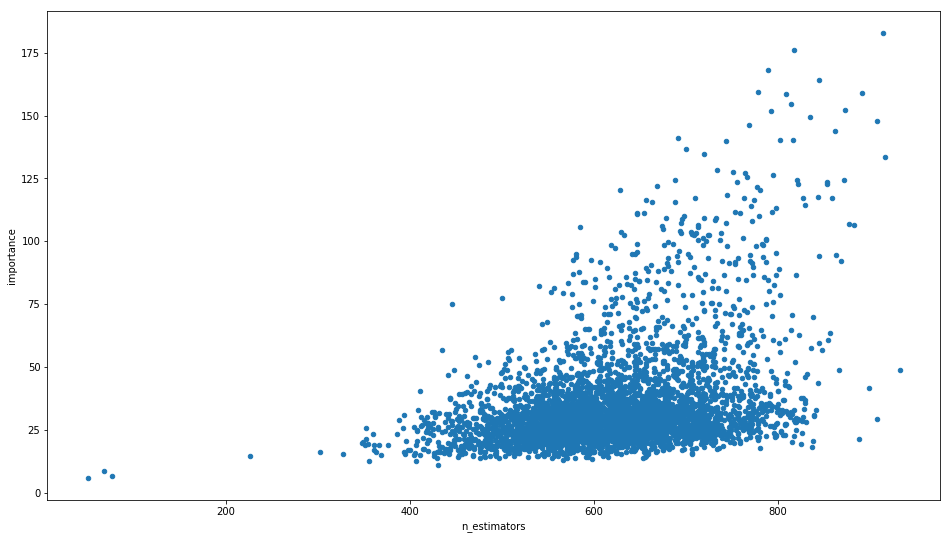

In [150]:
scatter_top_importance_by_rounds(net3_denorm, net3_meta, n=N)

## Interpretation

* the number of unique targets in the top 100K is much lower for normalized than denormalized SGBM
* the data quality of some targets probably ridiculously dominates the landscape

In [223]:
# len(net4_norm.merge(net4_denorm, on=['target'], how='inner')['target'].unique())

In [156]:
len(net3_norm['target'].unique())

1572

In [157]:
len(net3_denorm['target'].unique())

4300

In [174]:
def count_by_target(df):
    return pd.DataFrame(df.groupby(['target']).size(), columns=['count']).sort_values(by='count', ascending=False)

In [202]:
count_by_target(net3_norm).head()

,count
target,
G94,313
G1606,296
G45,291
G669,273
G821,242


* x-axis: nr of entries for a target
* y-axis: nr of targets with that nr of entries 

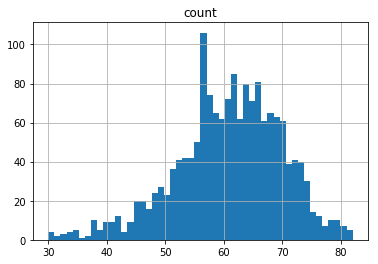

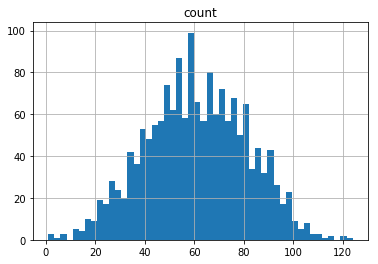

In [225]:
count_by_target(net1_norm).hist(bins=50)
count_by_target(net1_denorm).hist(bins=50)
plt.show()

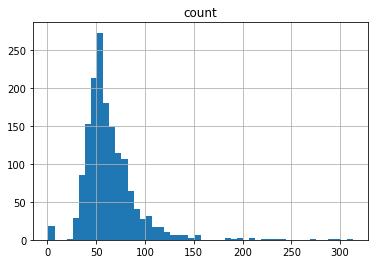

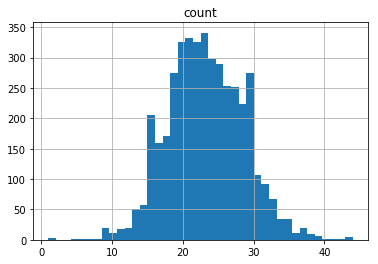

In [228]:
count_by_target(net3_norm).hist(bins=50)
count_by_target(net3_denorm).hist(bins=40)
plt.show()

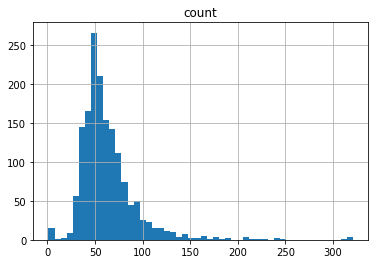

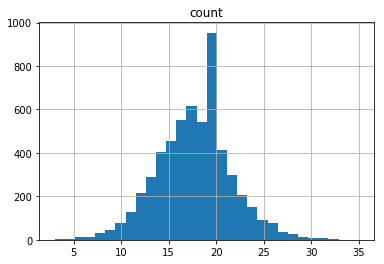

In [230]:
count_by_target(net4_norm).hist(bins=50)
count_by_target(net4_denorm).hist(bins=30)
plt.show()

In [278]:
norm_df = pd.DataFrame(count_by_target(net3_norm)).reset_index()
denorm_df = pd.DataFrame(count_by_target(net3_denorm)).reset_index()

norm_df.merge(denorm_df, on=['target'], how='outer').fillna(0).head()

,target,count_x,count_y
0,G94,313.0,26.0
1,G1606,296.0,27.0
2,G45,291.0,27.0
3,G669,273.0,20.0
4,G821,242.0,20.0


In [309]:
norm_df   = pd.DataFrame(count_by_target(net3_norm)).reset_index()
denorm_df = pd.DataFrame(count_by_target(net3_denorm)).reset_index()
merged_df = norm_df.merge(denorm_df, on=['target'], how='outer')  # .fillna(0) \
       
merged_df.merge(meta3).plot.scatter?

Object `plot.scatter` not found.


In [ ]:
merged_df.merge(meta3).plot.scatter

In [ ]:
merged_df.merge(meta3).scatter

In [337]:
def plot_counts(netX_norm, netX_denorm, meta, color):    
    norm_df = pd.DataFrame(count_by_target(netX_norm)).reset_index()
    denorm_df = pd.DataFrame(count_by_target(netX_denorm)).reset_index()
    merged_df = norm_df.merge(denorm_df, on=['target'], how='outer').merge(meta)
    
    merged_df.fillna(0) \
             .plot \
             .scatter(x='count_x', y='count_y', c=color, cmap=plt.get_cmap("viridis"))
           # .hexbin(x='count_x', y='count_y', bins='log', cmap=plt.get_cmap("inferno"))
            
    plt.show()

# Interpret this

In [339]:
def variances(ex_path):
    variances_df = pd.DataFrame(pd.read_csv(net3_ex_path, sep='\t').head().var()).reset_index()
    variances_df.columns=['target', 'variance']
    return variances_df

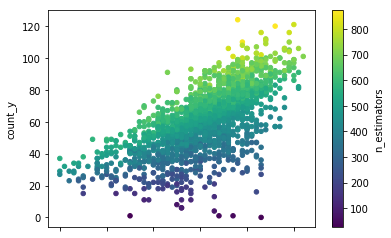

In [338]:
plot_counts(net1_norm, net1_denorm, meta1, 'n_estimators')

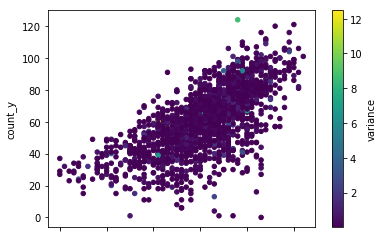

In [344]:
plot_counts(net1_norm, net1_denorm, variances(net1_ex_path), 'variance')

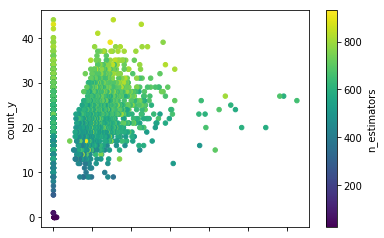

In [346]:
plot_counts(net3_norm, net3_denorm, meta3, 'n_estimators')

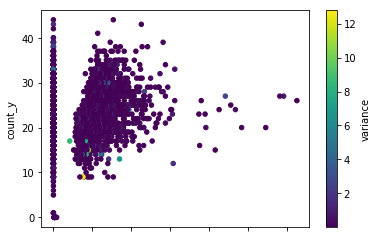

In [345]:
plot_counts(net3_norm, net3_denorm, variances(net3_ex_path), 'variance')

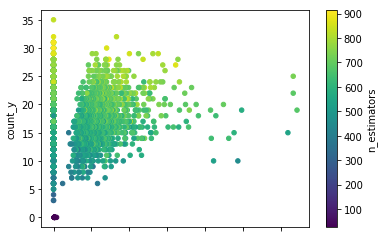

In [324]:
plot_counts(net4_norm, net4_denorm, meta4)

In [ ]:
count_by_target(net4_norm).merge

In [173]:
net3_denorm_count_by_target = pd.DataFrame(net1_denorm.groupby(['target']).size(), columns=['count']).sort_values(by='count', ascending=False)

In [ ]:
net1

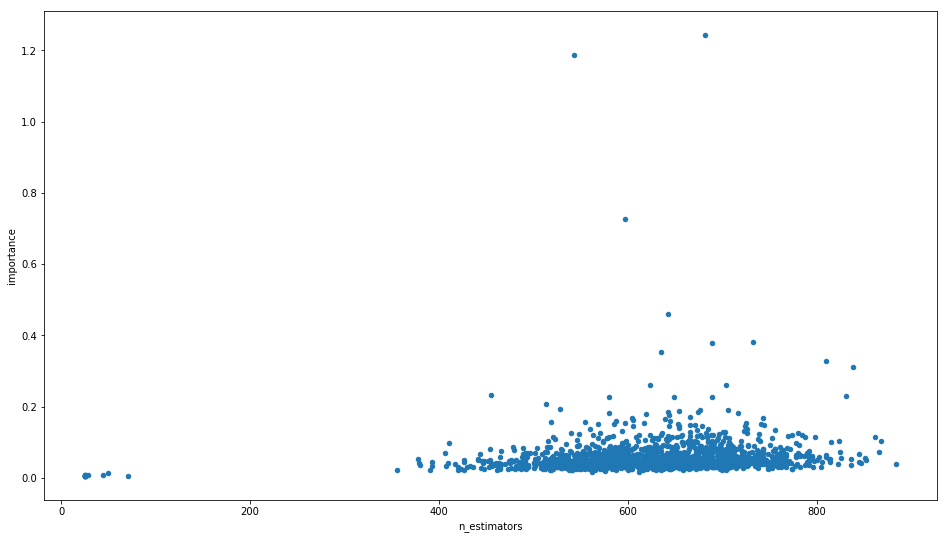

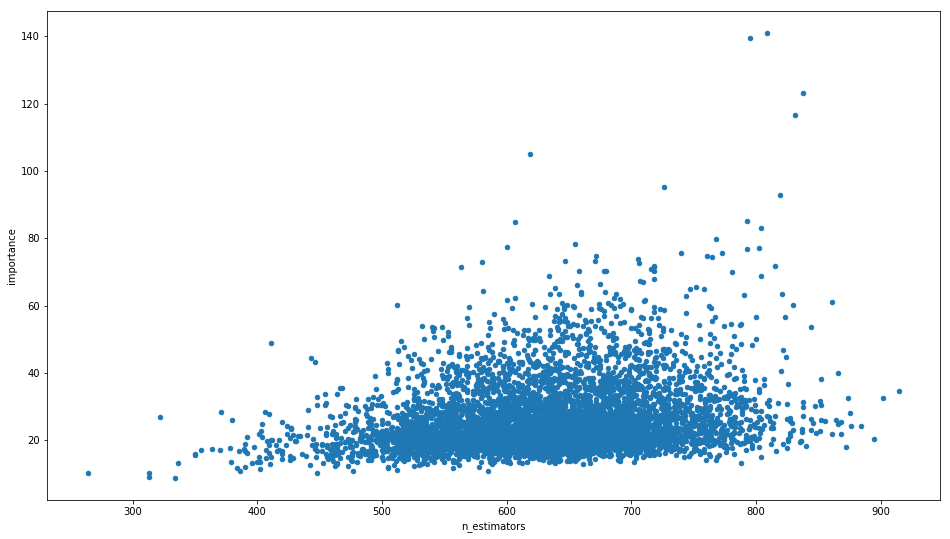

In [124]:
scatter_top_importance_by_rounds(net4_norm, net4_meta, n=N)
scatter_top_importance_by_rounds(net4_denorm, net4_meta, n=N)